### Our Zillow scenario continues:

#### As a Codeup data science graduate, you want to show off your skills to the Zillow data science team in hopes of getting an interview for a position you saw pop up on LinkedIn. You thought it might look impressive to build an end-to-end project in which you use some of their Kaggle data to predict property values using some of their available features; who knows, you might even do some feature engineering to blow them away. Your goal is to predict the values of single unit properties using the observations from 2017.

#### In these exercises, you will run through the stages of exploration as you continue to work toward the above goal.

## 1. As with encoded vs. unencoded data, we recommend exploring un-scaled data in your EDA process.

Note: This notebook will be dedicated exploring data for the final zillow regression project.
Meaningful columns for data acquisition:

### Acquire

In [ ]:
'bathroomcnt'
'bedroomcnt'
'calculatedfinishedsquarefeet'
'fips'
'lotsizesquarefeet' # maybe?
'rawcensustractandblock' # maybe?
'regionidcounty'
'yearbuilt'
'taxvaluedollarcnt'
'taxamount'

In [1]:
# Importing libraries

import pandas as pd
import numpy as np
import requests
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr, spearmanr
import statistics as s
import env

In [2]:
# Getting conncection to mySQL database, and acquiring data

def get_connection(db, user=env.user, host=env.host, password=env.password):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

# Loading raw data from Zillow database
def new_zillow_data():
    '''
    This function reads the Zillow data from the mySQL database into a df.
    '''
    # Create SQL query.
    sql_query = '''
    SELECT 
    CONCAT(SUBSTRING(longitude, 1, 4),
                    ',',
                    SUBSTRING(longitude, 5, 10)) as longitude,
    CONCAT(SUBSTRING(latitude, 1, 2),
                    ',',
                    SUBSTRING(latitude, 3, 10)) as latitude,
    bedroomcnt AS bedrooms,
    bathroomcnt AS bathrooms,
    calculatedfinishedsquarefeet AS square_feet,
    lotsizesquarefeet AS lot_size,
    poolcnt AS has_pool,
    CONCAT('0', fips) AS fips_code,
    (2017-yearbuilt) AS age,
    taxvaluedollarcnt AS assessed_value,
    taxamount AS tax_amount
FROM
    properties_2017 AS p
        JOIN
    predictions_2017 AS pred USING (parcelid)
        JOIN
    propertylandusetype AS ptype USING (propertylandusetypeid)
WHERE
    ptype.propertylandusedesc LIKE '%%Single%%'
        AND pred.transactiondate LIKE '2017%%';
    '''
    # Read in DataFrame from Codeup db.
    df = pd.read_sql(sql_query, get_connection('zillow'))
    
    return df

In [16]:
# load raw, messy data

rawdf = new_zillow_data()

In [17]:
rawdf.shape

(52441, 11)

### Prepare

#### Drop null values

In [5]:
rawdf.isnull().sum()

location            0
bedrooms            0
bathrooms           0
square_feet        82
lot_size          369
fips_code           0
year_built        116
assessed_value      1
tax_amount          4
dtype: int64

In [11]:
# Dropping null values

df = rawdf.dropna()

In [6]:
df.shape

(51956, 10)

#### Data types

In [12]:
df.dtypes

longitude          object
latitude           object
bedrooms          float64
bathrooms         float64
square_feet       float64
lot_size          float64
fips_code          object
age               float64
assessed_value    float64
tax_amount        float64
dtype: object

In [13]:
df['fips_code'] = df['fips_code'].astype(int)
df['age'] = df['age'].astype(int)

#### Data mapping?

##### Fips code:
- 6037 Los Angeles
- 6059 Orange
- 6111 Ventura


In [37]:
df['county'] = df.fips_code.map({6037: 'Los Angeles', 6059: 'Orange', 6111: 'Ventura'})

In [38]:
df.head()

longitude   latitude  bedrooms  bathrooms  square_feet  lot_size  \
0  -118,221043  34,184517       3.0        3.0       2538.0   39238.0   
1  -117,616376  33,644714       4.0        2.5       2761.0    5800.0   
2  -118,737528  34,262618       3.0        2.5       1371.0    4321.0   
3  -118,336609  34,181076       3.0        2.0       1676.0    7025.0   
4  -118,294446  33,814856       4.0        3.0       2352.0    5398.0   

   fips_code  age  assessed_value  tax_amount bedrooms_size bathrooms_size  \
0       6037   51        878288.0     9635.37        medium         medium   
1       6059   19        556255.0     8381.04        medium          small   
2       6111    5        404542.0     4705.74        medium          small   
3       6037   77        283892.0     3151.85        medium          small   
4       6037   28        293034.0     3839.25        medium         medium   

        county  
0  Los Angeles  
1       Orange  
2      Ventura  
3  Los Angeles  
4  Los Angeles

In [22]:
df.bathrooms.value_counts()

2.0     21816
3.0     10559
1.0      9503
2.5      3929
4.0      2160
3.5       912
1.5       832
5.0       773
4.5       682
6.0       300
5.5       224
7.0        87
8.0        52
6.5        47
0.0        41
7.5        16
9.0        12
10.0        5
11.0        3
8.5         2
13.0        1
Name: bathrooms, dtype: int64

#### Dummies

In [36]:
df.dtypes

longitude           object
latitude            object
bedrooms           float64
bathrooms          float64
square_feet        float64
lot_size           float64
fips_code            int64
age                  int64
assessed_value     float64
tax_amount         float64
bedrooms_size     category
bathrooms_size    category
dtype: object

In [ ]:
- bedrooms:
    - small: 1, 2
    - medium: 3, 4
    - large: 5, 6
- bathrooms: 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5,5, 6, 6.5
    - small: 1, 1.5, 2, 2.5
    - medium: 3, 3.5, 4, 4.5
    - large: 5, 5.5, 6, 6.5

In [24]:
df['bedrooms_size'] = pd.cut(df.bedrooms, bins = [0,2,4,6],
                            labels = ['small', 'medium', 'large'])

In [33]:
df['bathrooms_size'] = pd.cut(df.bathrooms, bins = [0,2.5,4.5,6.5],
                            labels = ['small', 'medium', 'large'])

In [39]:
# Make dummy columns and concatenate on original dataframe 
dummy_df = pd.get_dummies(df[['county', 'bedrooms_size', 'bathrooms_size']], dummy_na=False, drop_first=False)
df = pd.concat([df, dummy_df], axis=1)

In [40]:
df.head()

longitude   latitude  bedrooms  bathrooms  square_feet  lot_size  \
0  -118,221043  34,184517       3.0        3.0       2538.0   39238.0   
1  -117,616376  33,644714       4.0        2.5       2761.0    5800.0   
2  -118,737528  34,262618       3.0        2.5       1371.0    4321.0   
3  -118,336609  34,181076       3.0        2.0       1676.0    7025.0   
4  -118,294446  33,814856       4.0        3.0       2352.0    5398.0   

   fips_code  age  assessed_value  tax_amount  ...       county  \
0       6037   51        878288.0     9635.37  ...  Los Angeles   
1       6059   19        556255.0     8381.04  ...       Orange   
2       6111    5        404542.0     4705.74  ...      Ventura   
3       6037   77        283892.0     3151.85  ...  Los Angeles   
4       6037   28        293034.0     3839.25  ...  Los Angeles   

  county_Los Angeles county_Orange  county_Ventura  bedrooms_size_small  \
0                  1             0               0                    0   
1                  0             1               0                    0   
2                  0             0               1                    0   
3                  1             0               0                    0   
4                  1             0               0                    0   

   bedrooms_size_medium  bedrooms_size_large  bathrooms_size_small  \
0                     1                    0                     0   
1                     1                    0                     1   
2                     1                    0                     1   
3                     1                    0                     1   
4                     1                    0                     0   

   bathrooms_size_medium  bathrooms_size_large  
0                      1                     0  
1                      0                     0  
2                      0                     0  
3                      0                     0  
4                      1                     0  

[5 rows x 22 columns]

#### Outliers

In [13]:
# Display format
pd.options.display.float_format = '{:,.2f}'.format

<Figure size 432x432 with 0 Axes>

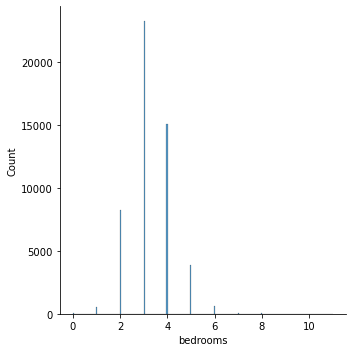

In [17]:
plt.figure(figsize = (6, 6))

sns.displot(x='bedrooms', data=df)

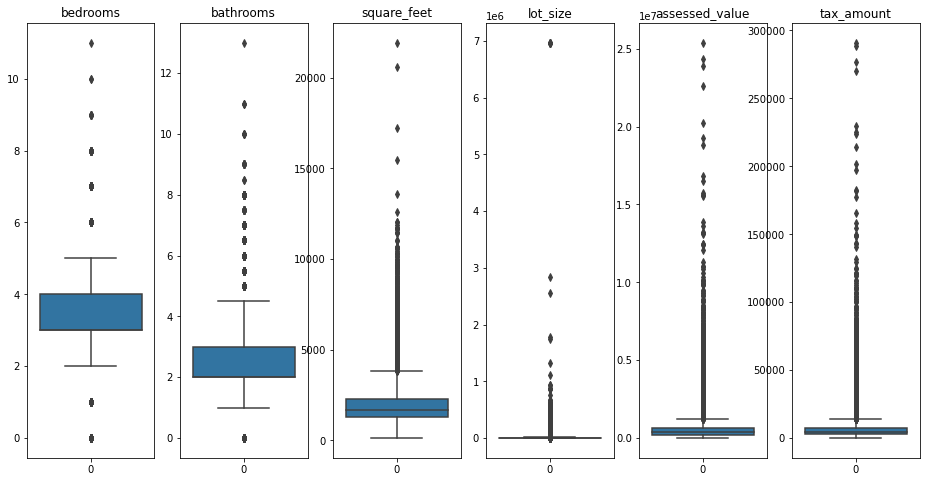

In [18]:
plt.figure(figsize = (16,8))

# List of columns
cols = ['bedrooms', 'bathrooms', 'square_feet','lot_size','assessed_value', 'tax_amount']

for i, col in enumerate(cols):
    
    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 
    
    # Create subplot.
    plt.subplot(1,6, plot_number)
    
    # Title with column name.
    plt.title(col)
    
    # Display histogram for column.
    sns.boxplot(data = df[col])


#### General rules:

lower bound: Q1 – (1.5 * IQR)
upper bound: Q3 + (1.5 * IQR)

##### bedrooms

In [19]:
df.bedrooms.describe()

count   51,956.00
mean         3.30
std          0.93
min          0.00
25%          3.00
50%          3.00
75%          4.00
max         11.00
Name: bedrooms, dtype: float64

In [17]:
q1 = np.percentile(df.bedrooms, 25)
q3 = np.percentile(df.bedrooms, 75)
iqr = q3 - q1
print("IQR equals: " + str(iqr))

IQR equals: 1.0


In [18]:
print("Upper bond for bedrooms: ", q3 + 2.5*iqr)
print("Lower bond for bedrooms: ", q1 - 2*iqr)

Upper bond for bedrooms:  6.5
Lower bond for bedrooms:  1.0


In [20]:
df[df.bedrooms>=7].shape

(138, 10)

##### bathrooms

In [23]:
df.bathrooms.describe()

count   51,956.00
mean         2.30
std          1.01
min          0.00
25%          2.00
50%          2.00
75%          3.00
max         13.00
Name: bathrooms, dtype: float64

In [24]:
q1 = np.percentile(df.bathrooms, 25)
q3 = np.percentile(df.bathrooms, 75)
iqr = q3 - q1
print("IQR equals: " + str(iqr))

IQR equals: 1.0


In [25]:
print("Upper bond for bedrooms: ", q3 + 3.5*iqr)
print("Lower bond for bedrooms: ", q1 - 1.5*iqr)

Upper bond for bedrooms:  6.5
Lower bond for bedrooms:  0.5


In [26]:
df[df.bathrooms>6.5].shape

(178, 10)

##### square_feet

In [27]:
df.square_feet.describe()

count   51,956.00
mean     1,918.27
std        994.32
min        128.00
25%      1,268.00
50%      1,657.00
75%      2,301.00
max     21,929.00
Name: square_feet, dtype: float64

In [28]:
q1 = np.percentile(df.square_feet, 25)
q3 = np.percentile(df.square_feet, 75)
iqr = q3 - q1
print("IQR equals: " + str(iqr))

IQR equals: 1033.0


In [29]:
print("Upper bond for square_feet: ", q3 + 5.5*iqr)
print("Lower bond for square_feet: ", q1 - 0.75*iqr)

Upper bond for square_feet:  7982.5
Lower bond for square_feet:  493.25


In [30]:
df[df.square_feet>7982].shape

(102, 10)

In [31]:
df[df.square_feet<493].shape

(73, 10)

##### lot_size

In [32]:
df.lot_size.describe()

count      51,956.00
mean       11,251.78
std        86,643.13
min           236.00
25%         5,581.00
50%         6,838.00
75%         8,777.00
max     6,971,010.00
Name: lot_size, dtype: float64

In [33]:
q1 = np.percentile(df.lot_size, 25)
q3 = np.percentile(df.lot_size, 75)
iqr = q3 - q1
print("IQR equals: " + str(iqr))

IQR equals: 3196.0


In [34]:
print("Upper bond for square_feet: ", q3 + 45*iqr)
print("Lower bond for square_feet: ", q1 - 1.5*iqr)

Upper bond for square_feet:  152597.0
Lower bond for square_feet:  787.0


In [35]:
df[df.lot_size>152597].shape

(171, 10)

In [36]:
df[df.lot_size<787].shape

(55, 10)

##### assessed_value

In [37]:
df.assessed_value.describe()

count       51,956.00
mean       525,518.65
std        716,429.97
min          1,000.00
25%        193,478.50
50%        372,791.00
75%        616,656.25
max     25,381,250.00
Name: assessed_value, dtype: float64

In [38]:
q1 = np.percentile(df.assessed_value, 25)
q3 = np.percentile(df.assessed_value, 75)
iqr = q3 - q1
print("IQR equals: " + str(iqr))

IQR equals: 423177.75


In [39]:
print("Upper bond for assessed_value: ", q3 + 4.5*iqr)
print("Lower bond for assessed_value: ", q1 - 0.35 *iqr)

Upper bond for assessed_value:  2520956.125
Lower bond for assessed_value:  45366.287500000006


In [40]:
df[df.assessed_value<45366].shape[0]/df.shape[0]

0.019478019862960966

In [41]:
df[df.assessed_value>2520956].shape[0]/df.shape[0]

0.016206020478866733

##### outliers summary

In [17]:
df = df[df.bedrooms <= 6.5]
df = df[df.bedrooms >= 1]

df = df[df.bathrooms <= 6.5]
df = df[df.bathrooms >= 0.5]

df = df[df.square_feet <= 7982]
df = df[df.square_feet >= 493]

df = df[df.lot_size <= 152597]
df = df[df.lot_size >= 787]

df = df[df.assessed_value <= 2520956]
df = df[df.assessed_value >= 45366]

In [43]:
df.shape

(49633, 10)

#### Split data

In [14]:
def split(df):
    '''
    This function drops the customer_id column and then splits a dataframe into 
    train, validate, and test in order to explore the data and to create and validate models. 
    It takes in a dataframe and contains an integer for setting a seed for replication. 
    Test is 20% of the original dataset. The remaining 80% of the dataset is 
    divided between valiidate and train, with validate being .30*.80= 24% of 
    the original dataset, and train being .70*.80= 56% of the original dataset. 
    The function returns, train, validate and test dataframes. 
    '''
    train, test = train_test_split(df, test_size = .2, random_state=123)   
    train, validate = train_test_split(train, test_size=.3, random_state=123)
    
    return train, validate, test

In [59]:
df = prep_zillow(rawdf)

In [62]:
df.has_pool.sum()

10381.0

In [58]:
# Prepare.py functions:

def prep_zillow(df):
    df.has_pool.fillna(value = 0)
    # Drop outliers
    df = df.dropna()
    
    # Change data type
    df['fips_code'] = df['fips_code'].astype(int)
    df['age'] = df['age'].astype(int)
    
    # Data mapping
    df['county'] = df.fips_code.map({6037: 'Los Angeles', 6059: 'Orange', 6111: 'Ventura'})
    
    df['bedrooms_size'] = pd.cut(df.bedrooms, bins = [0,2,4,6],
                            labels = ['small', 'medium', 'large'])
    df['bathrooms_size'] = pd.cut(df.bathrooms, bins = [0,2.5,4.5,6.5],
                            labels = ['small', 'medium', 'large'])

    # Drop column
    # df = df.drop(['fips_code'], axis=1)
    
    # Make dummy columns and concatenate on original dataframe 
    dummy_df = pd.get_dummies(df[['county', 'bedrooms_size', 'bathrooms_size']], dummy_na=False, drop_first=False)
    df = pd.concat([df, dummy_df], axis=1)
    
    # Handle Outliers:
    # The general rule for outliers are:
    ## Upper bond: Q3 + 1.5*IQR
    ## Lower bund: Q1 - 1.5*IQR
    # Bonds are manually adjusted for each feature
    df = df[df.bedrooms <= 6]
    df = df[df.bedrooms >= 1]

    df = df[df.bathrooms <= 6.5]
    df = df[df.bathrooms >= 0.5]

    df = df[df.square_feet <= 7982]
    df = df[df.square_feet >= 493]

    df = df[df.lot_size <= 152597]
    df = df[df.lot_size >= 787]

    df = df[df.assessed_value <= 2520956]
    df = df[df.assessed_value >= 45366]
    
    return df
    

def split(df):
    '''
    This function drops the customer_id column and then splits a dataframe into 
    train, validate, and test in order to explore the data and to create and validate models. 
    It takes in a dataframe and contains an integer for setting a seed for replication. 
    Test is 20% of the original dataset. The remaining 80% of the dataset is 
    divided between valiidate and train, with validate being .30*.80= 24% of 
    the original dataset, and train being .70*.80= 56% of the original dataset. 
    The function returns, train, validate and test dataframes. 
    '''
    train, test = train_test_split(df, test_size = .2, random_state=123)   
    train, validate = train_test_split(train, test_size=.3, random_state=123)
    
    return train, validate, test

## 2. Make sure to perform a train, validate, test split before and use only your train dataset to explore the relationships between independent variables with other independent variables or independent variables with your target variable.

In [47]:
train.head()

latitude       longitude  bedrooms  bathrooms  square_feet  \
37569 33,863,169.00 -118,076,077.00      2.00       1.00       752.00   
34742 34,229,579.00 -118,605,717.00      4.00       2.00     1,795.00   
17160 34,137,359.00 -118,406,170.00      3.00       2.00     1,458.00   
37728 34,311,526.00 -118,421,146.00      3.00       2.00     1,173.00   
22416 33,554,928.00 -117,631,141.00      3.00       2.50     1,828.00   

       lot_size  year_built  assessed_value  tax_amount       county  
37569  4,578.00        1945      344,000.00    4,288.63  Los Angeles  
34742 13,305.00        1963       79,896.00    1,190.07  Los Angeles  
17160 13,304.00        1950      527,847.00    6,478.29  Los Angeles  
37728  7,337.00        1957      342,234.00    4,137.93  Los Angeles  
22416  2,414.00        2002      600,609.00    8,503.78       Orange

## 3. Write a function named `plot_variable_pairs` that accepts a dataframe as input and plots all of the pairwise relationships along with the regression line for each pair.

In [48]:
def plot_variable_pairs(df):
    return sns.pairplot(df, corner = True, kind='reg', plot_kws={'line_kws':{'color':'red'}, 'scatter_kws':{'s': 1, 'alpha': 0.5}})

<Figure size 1440x1440 with 0 Axes>

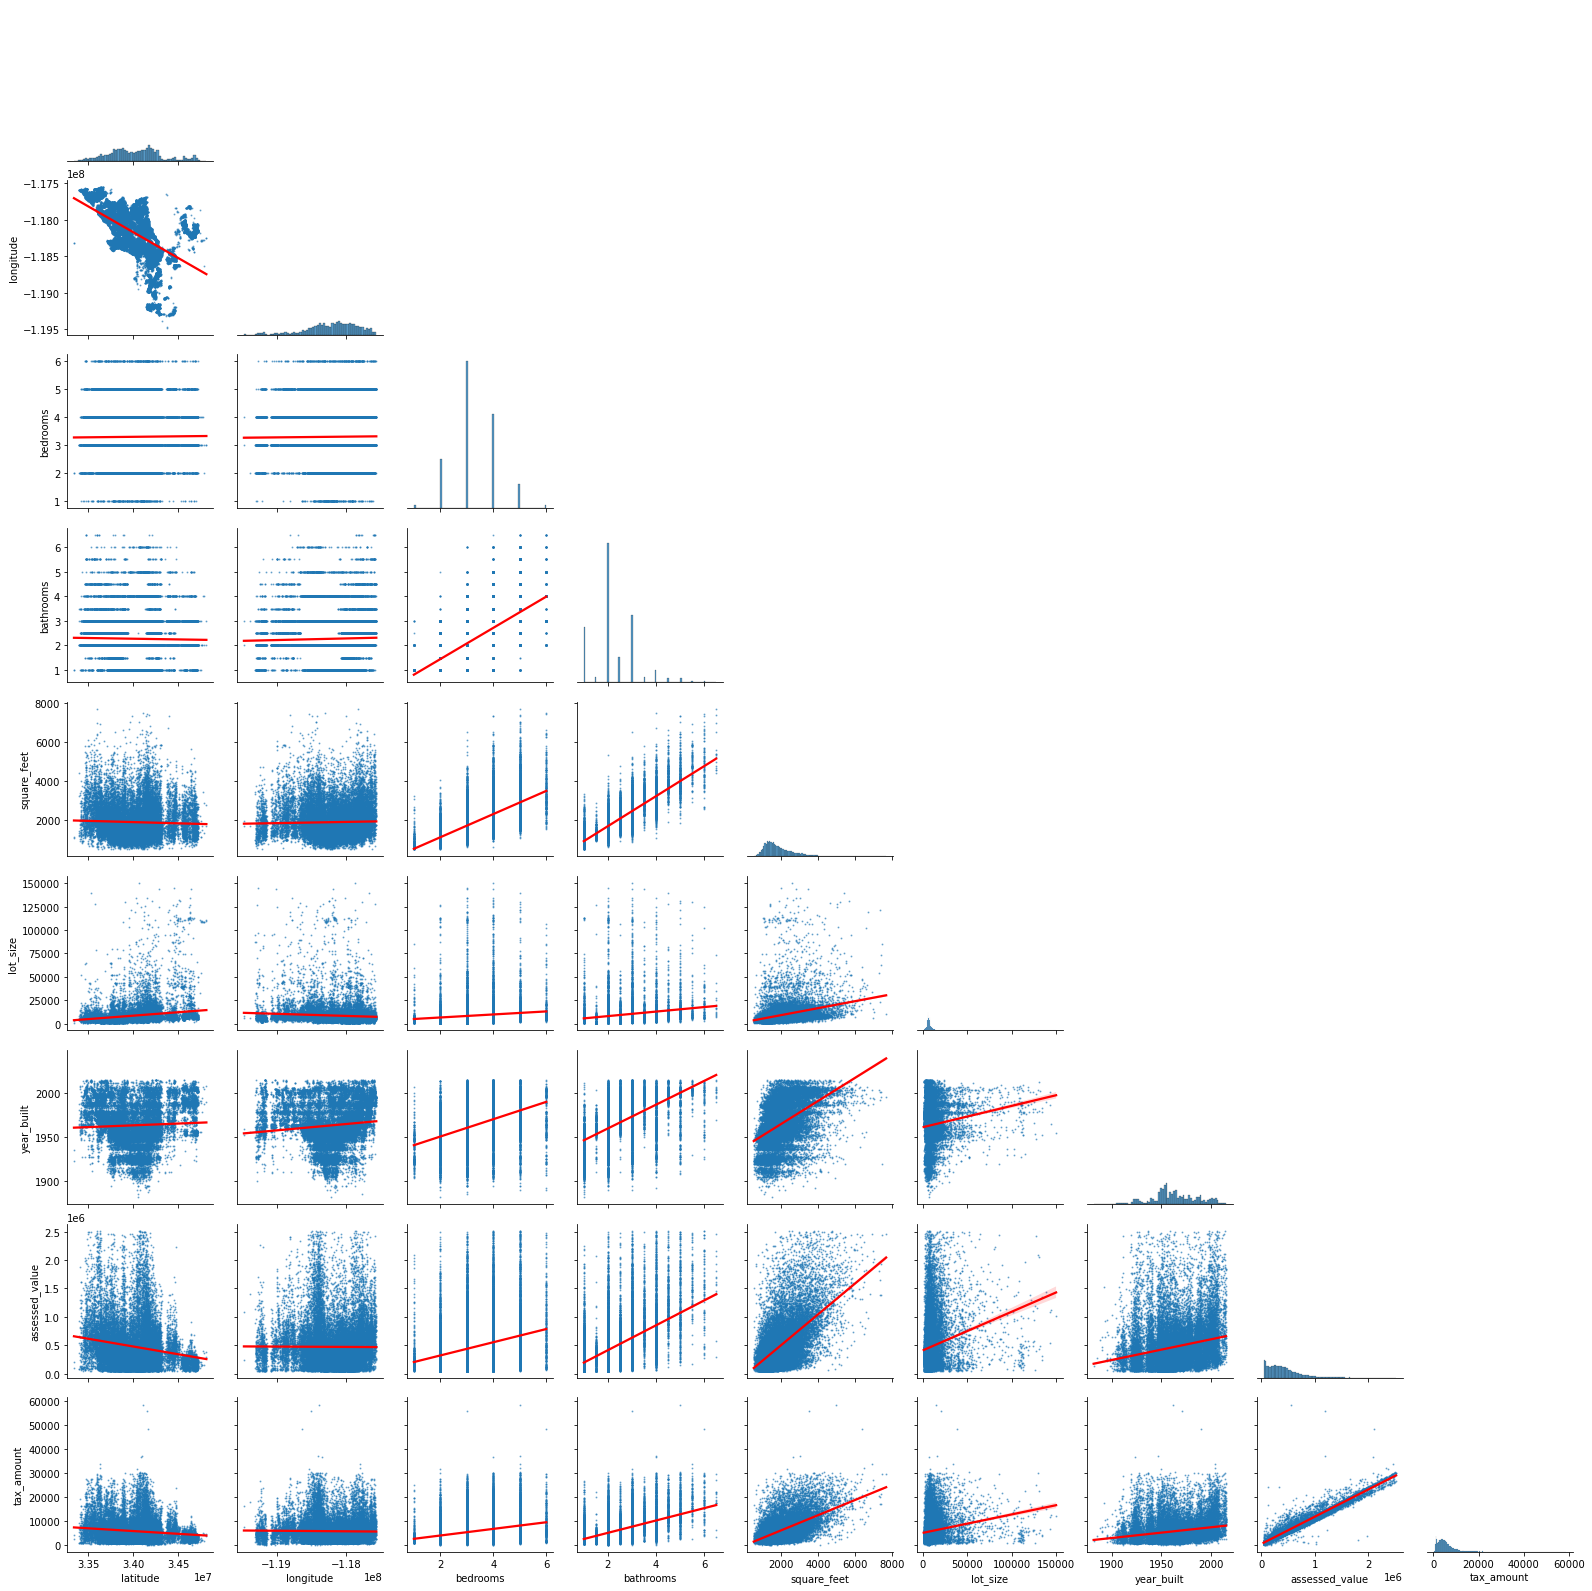

In [49]:
# ploting pairplot
plt.figure(figsize= (20,20))

plot_variable_pairs(train)

## 4. Write a function named `plot_categorical`_and_`continuous_vars` that accepts your dataframe and the name of the columns that hold the continuous and categorical features and outputs 3 different plots for visualizing a categorical variable and a continuous variable.

In [43]:
train.columns

Index(['location', 'bedrooms', 'bathrooms', 'square_feet', 'lot_size',
       'fips_code', 'year_built', 'assessed_value', 'tax_amount', 'county'],
      dtype='object')

In [50]:
categorical_cols = ['bedrooms', 'bathrooms','county', 'year_built']
continuous_cols = ['square_feet', 
                  'lot_size', 'assessed_value', 'tax_amount']

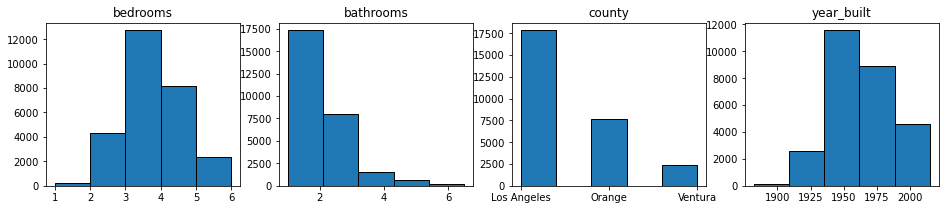

In [82]:
plt.figure(figsize=(16, 3))

for i, col in enumerate(categorical_cols):
    
    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1
    
    # Create subplot.
    # plt.subplot(row X col, where?)
    plt.subplot(1,len(categorical_cols),plot_number)
    
    # Title with column name.
    plt.title(col)
    
    # Display histogram for column.
    train[col].hist(bins=5, edgecolor='black')
    
    # Hide gridlines.
    plt.grid(False)

In [64]:
train.bathrooms.value_counts()

2.00    12031
3.00     5846
1.00     4814
2.50     2201
4.00     1106
3.50      470
1.50      449
4.50      345
5.00      343
5.50       92
6.00       82
6.50       15
Name: bathrooms, dtype: int64

## 5. Save the functions you have written to create visualizations in your explore.py file. Rewrite your notebook code so that you are using the functions imported from this file.

## 6. Use the functions you created above to explore your Zillow train dataset in your explore.ipynb notebook.

## 7. Come up with some initial hypotheses based on your goal of predicting property value.

## 8. Visualize all combinations of variables in some way.

In [61]:
train_corr = train[continuous_cols].corr()
train_corr

bedrooms  bathrooms  square_feet  lot_size  assessed_value  \
bedrooms            1.00       0.62         0.63      0.15            0.26   
bathrooms           0.62       1.00         0.83      0.22            0.51   
square_feet         0.63       0.83         1.00      0.31            0.58   
lot_size            0.15       0.22         0.31      1.00            0.17   
assessed_value      0.26       0.51         0.58      0.17            1.00   
tax_amount          0.27       0.51         0.58      0.17            0.97   

                tax_amount  
bedrooms              0.27  
bathrooms             0.51  
square_feet           0.58  
lot_size              0.17  
assessed_value        0.97  
tax_amount            1.00

<AxesSubplot:>

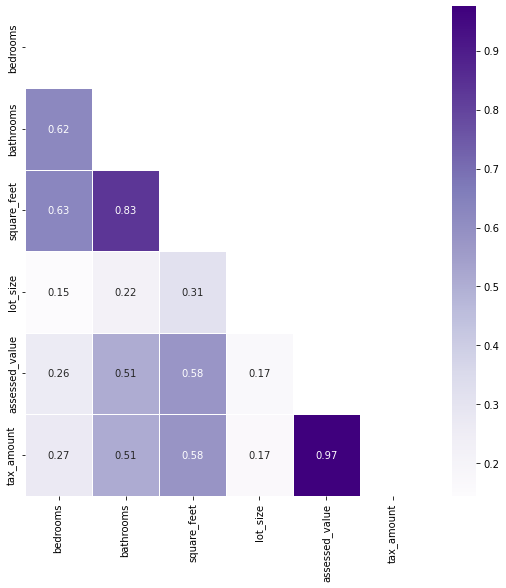

In [62]:
plt.figure(figsize = (9,9))
sns.heatmap(train_corr,cmap='Purples', annot=True, linewidth=0.5, mask= np.triu(train_corr))

## 9. Run the appropriate statistical tests where needed.

In [46]:
def plot_categorical_and_continuous_vars(df, categorical, continuous):
    for num in continuous:
        for cat in categorical:
            _, ax = plt.subplots(1,3,figsize=(20,8))
            p = sns.swarmplot(data = df, x=cat, y=num, ax=ax[0])
            p.axhline(df[num].mean())
            p = sns.boxplot(data = df, x=cat, y = num, ax=ax[1])
            p.axhline(df[num].mean())
            p = sns.violinplot(data = df, x=cat, y=num, hue = cat, ax=ax[2])
            p.axhline(df[num].mean())
            plt.suptitle(f'{num} by {cat}', fontsize = 18)
            plt.show()

In [ ]:
plot_categorical_and_continuous_vars(train, categorical_cols, continuous_cols)

## 10. What independent variables are correlated with the dependent variable, home value?

## 11. Which independent variables are correlated with other independent variables (bedrooms, bathrooms, year built, square feet)?

## 12. Make sure to document your takeaways from visualizations and statistical tests as well as the decisions you make throughout your process.

## 13. Explore your dataset with any other visualizations you think will be helpful.

In [27]:
import plotly.express as px
import geopandas as gpd
import json

In [29]:
zillow_geo = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -119.33898925781251,
              34.31621838080741
            ],
            [
              -119.31427001953125,
              34.19817309627726
            ],
            [
              -118.74847412109375,
              33.868135032968624
            ],
            [
              -117.74322509765624,
              33.4039312002347
            ],
            [
              -117.58392333984375,
              33.43144133557529
            ],
            [
              -117.60040283203125,
              33.881817226884806
            ],
            [
              -118.11950683593749,
              34.266296360583546
            ],
            [
              -118.99291992187499,
              34.45221847282654
            ],
            [
              -119.30877685546876,
              34.4861839632883
            ],
            [
              -119.33898925781251,
              34.31621838080741
            ]
          ]
        ]
      }
    }
  ]
}

In [36]:
zillow_geo['features'][0]['geometry']

{'type': 'Polygon',
 'coordinates': [[[-119.33898925781251, 34.31621838080741],
   [-119.31427001953125, 34.19817309627726],
   [-118.74847412109375, 33.868135032968624],
   [-117.74322509765624, 33.4039312002347],
   [-117.58392333984375, 33.43144133557529],
   [-117.60040283203125, 33.881817226884806],
   [-118.11950683593749, 34.266296360583546],
   [-118.99291992187499, 34.45221847282654],
   [-119.30877685546876, 34.4861839632883],
   [-119.33898925781251, 34.31621838080741]]]}

In [39]:
fig = px.choropleth(train, geojson=zillow_geo['features'][0]['geometry'], locations='location', color='assessed_value',
                           color_continuous_scale="Viridis",
                           range_color=(0, 12),
                           scope="usa",
                           labels={'housing value':'assessed_value'}
                          )

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [42]:
fig = px.choropleth(train, locations=["CA"], locationmode="USA-states", color=[1], scope="usa")
 
fig.show()

In [21]:
import plotly.graph_objects as go

In [148]:
graph = pd.read_csv('zillow_graph.csv')

In [150]:
graph.columns

Index(['Unnamed: 0', 'propertylandusetypeid', 'parcelid', 'id',
       'airconditioningtypeid', 'architecturalstyletypeid', 'basementsqft',
       'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid',
       'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertyzoningdesc',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty',
       'regionidneighborhood', 'regionidzip', 'roomcnt', 'storytypeid',
       'threequarterbathnbr', 'typeconstructiontypeid', 'unitcnt',
       'yardbu

In [25]:
fig = go.Figure(data = go.Choropleth(locations = train['location'],
                                     z=train['assessed_value'],
                                     locationmode = 'USA-states',
                                     colorscale = 'Blues',
                                     colorbar_title = 'housing prices',
                                     text = train['assessed_value']))
fig.show()